In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Activation

from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import fbeta_score
from sklearn.metrics import log_loss

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit


import seaborn as sns

from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, ELU, Add
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

from keras.preprocessing.image import ImageDataGenerator

from sys import platform
from sklearn import preprocessing
import os

from multiprocessing import Pool, cpu_count
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import fbeta_score
from PIL import Image, ImageStat
import pandas as pd
import numpy as np
import glob, cv2

from scipy.stats import kurtosis, skew
from scipy.ndimage import laplace, sobel

from random import choice

from numpy import matrix
from numpy import linalg
import math


Using TensorFlow backend.


In [2]:
if platform == "linux":
    dataDir = "/home/donchan/Documents/myData/KaggleData/Iceberg"
else:
    dataDir = "/Users/donchan/Documents/myData/KaggleData/Iceberg"
train_data = os.path.join(dataDir,"data/processed/train.json")
test_data = os.path.join(dataDir,"data/processed/test.json")

print("load data...")


train = pd.read_json(train_data)
test = pd.read_json(test_data)
#train.inc_angle = train.inc_angle.replace('na', 0)
#train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
print("done!")

angle = train.inc_angle.copy()
angle = angle.replace('na',np.nan)

angle_median = angle.median()
angle_mean = angle.mean()
angle = angle.astype(np.float32).fillna(angle_median)


load data...
done!


In [3]:
x_band1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
x_band2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])

x1_shape = x_band1.shape
x2_shape = x_band2.shape

scaler = preprocessing.StandardScaler()
mm_scaler = preprocessing.MinMaxScaler()
stand_x_band1 = mm_scaler.fit_transform(x_band1.reshape(-1,1))
stand_x_band2 = mm_scaler.fit_transform(x_band2.reshape(-1,1))
x_band1_st = stand_x_band1.reshape(x1_shape)
x_band2_st = stand_x_band2.reshape(x2_shape)

In [4]:
X_train = np.concatenate([x_band1_st[:, :, :, np.newaxis]
                          , x_band2_st[:, :, :, np.newaxis]
                         , ((x_band1_st+x_band1_st)/2)[:, :, :, np.newaxis]], axis=-1)

X_train_orig = np.concatenate([x_band1[:, :, :, np.newaxis]
                          , x_band2[:, :, :, np.newaxis]
                         , ((x_band1+x_band1)/2)[:, :, :, np.newaxis]], axis=-1)



X_angle_train = np.array(train.inc_angle)

In [12]:
im = Image.fromarray(x_band1[0])
im.size

(75, 75)

In [13]:
def rot_x(angle,ptx,pty):
    return math.cos(angle)*ptx + math.sin(angle)*pty

def rot_y(angle,ptx,pty):
    return -math.sin(angle)*ptx + math.cos(angle)*pty


def rotate(x_band):
    im = Image.fromarray(x_band)
    angle = math.radians(45)
    (x,y) = im.size
    xextremes = [rot_x(angle,0,0),rot_x(angle,0,y-1),rot_x(angle,x-1,0),rot_x(angle,x-1,y-1)]
    yextremes = [rot_y(angle,0,0),rot_y(angle,0,y-1),rot_y(angle,x-1,0),rot_y(angle,x-1,y-1)]
    mnx = min(xextremes)
    mxx = max(xextremes)
    mny = min(yextremes)
    mxy = max(yextremes)
    #print mnx,mny
    T = matrix([[math.cos(angle),math.sin(angle),-mnx],[-math.sin(angle),math.cos(angle),-mny],[0,0,1]])
    Tinv = linalg.inv(T);
    #print Tinv
    Tinvtuple = (Tinv[0,0],Tinv[0,1], Tinv[0,2], Tinv[1,0],Tinv[1,1],Tinv[1,2])
    #print Tinvtuple
    im = im.transform((int(round(mxx-mnx)),int(round((mxy-mny)))),Image.AFFINE,Tinvtuple,resample=Image.BILINEAR)
                      
    return im

In [19]:
r = rotate(x_band1_st[0])

0.0 -52.3259018078
[[  0.70710678  -0.70710678  37.        ]
 [  0.70710678   0.70710678 -37.        ]
 [  0.           0.           1.        ]]
(0.70710678118654757, -0.70710678118654746, 36.999999999999993, 0.70710678118654746, 0.70710678118654757, -37.0)


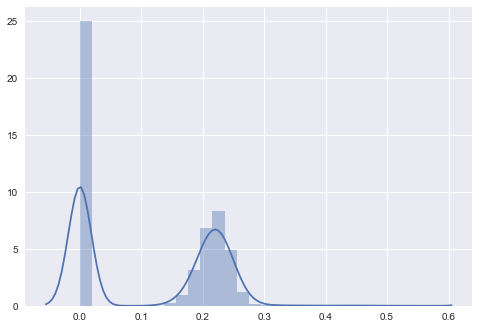

In [20]:
sns.distplot(np.array(r).ravel())

(<matplotlib.image.AxesImage at 0x116046ad0>, (105, 105))

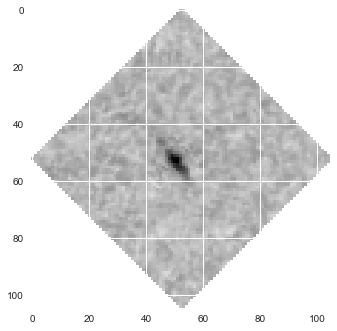

In [22]:
plt.imshow(np.array(r)),r.size

In [24]:
im_band1_st = map(Image.fromarray, x_band1_st)

In [32]:
im = im_band1_st[0].rotate(30)

(<matplotlib.image.AxesImage at 0x12e226990>, (75, 75))

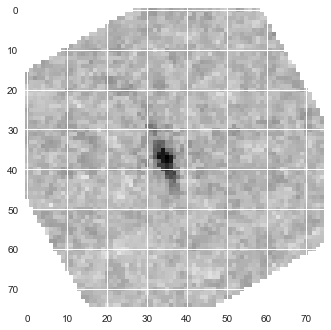

In [33]:
plt.imshow(np.array(im)),im.size

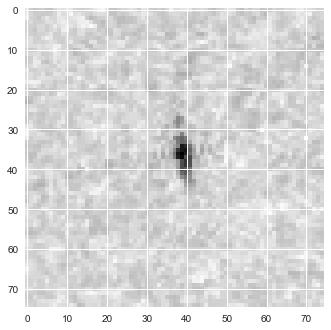

In [37]:
plt.imshow( cv2.flip(x_band1[0],1) )